In [1]:
import pygmt 
import pandas as pd
import numpy as np
from scipy import optimize
from obspy import geodetics,UTCDateTime
import os

In [2]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [3]:
# 计算震相走时等信息
def read_station(stafile):
    data_type = {'station':str}
    stations = pd.read_csv(stafile,sep='\s+',names=['station','latitude','longitude','elevation'],dtype=data_type)
    sta_dict = {}
    for i in range(len(stations)):
        staline = stations.iloc[i]
        station = staline['station']
        latitude = staline['latitude']
        longitude = staline['longitude']
        elevation = staline['elevation']
        sta_dict[station] = {'latitude':latitude,'longitude':longitude,'elevation':elevation}
    return sta_dict,stations
def read_pha(phafile,stafile):
    sta_dict,sta_df = read_station(stafile)
    phase = []
    catalog = []
    with open(phafile,'r') as fp:
        for line in fp:
            tmp = line.split()
            if tmp[0] == "#":
                flag,year,month,day,hour,minute,second,lat,lon,dep,mag,eh,ez,rms,evtid = line.split()
                head = line
                time = UTCDateTime(int(year),int(month),int(day),int(hour),int(minute),0,0)+float(second)
                catalog.append([float(lat),float(lon),float(dep),float(mag),evtid,time])
            else:
                sta,tt,weight,phase_hint = line.split()
                sta = sta.upper()
                if sta in list(sta_dict):
                    stlo,stla = sta_dict[sta]['longitude'],sta_dict[sta]['latitude']
                    distance,_,_ = geodetics.gps2dist_azimuth(lat1=stla, lon1=stlo, lat2=float(lat), lon2=float(lon))
                    epi_distance = distance/1000
                    hyp_distance = np.sqrt(epi_distance**2+float(dep)**2)
                    phase.append([head,sta,epi_distance,hyp_distance,float(tt),float(weight),phase_hint[0]])
                else:
                    print(sta,' not in the station file')
    phase = pd.DataFrame(data=phase,columns=['evtid','sta','epi_distance','hyp_distance','tt','weight','pha'])
    catalog_df = pd.DataFrame(data=catalog,columns=['latitude','longitude','depth','magnitude','evtid','time'])
    return phase,catalog_df,sta_df

In [4]:
InputData = 'TGR_data//tomoDD09/ph2dt'
stafile = InputData+os.sep+'station.dat'
phafile = InputData+os.sep+'new_original.dat'
phase,catalog_df,sta_df = read_pha(phafile, stafile)
Tp = phase[phase['pha'] == 'P']
Ts = phase[phase['pha'] == 'S']

ty = 'hyp_distance'
#ty = 'epi_distance'
region1 = [phase[ty].min()-1,phase[ty].max()+1,phase.tt.min()-1,phase.tt.max()+1]
print('Total events:',len(catalog_df))
print("Sum of initial P-wave times:",len(Tp))
print("Sum of initial S-wave times:",len(Ts))

Total events: 5224
Sum of initial P-wave times: 41423
Sum of initial S-wave times: 42345


In [5]:
phafile = InputData+os.sep+'new.dat'
phase,catalog_df,sta_df = read_pha(phafile, stafile)
Tp_ff = phase[phase['pha'] == 'P']
Ts_ff = phase[phase['pha'] == 'S']
region2 = [phase[ty].min()-1,phase[ty].max()+1,phase.tt.min()-1,phase.tt.max()+1]
print('Total events:',len(catalog_df))
print("Sum of initial P-wave times:",len(Tp_ff))
print("Sum of initial S-wave times:",len(Ts_ff))

Total events: 5082
Sum of initial P-wave times: 40824
Sum of initial S-wave times: 41578


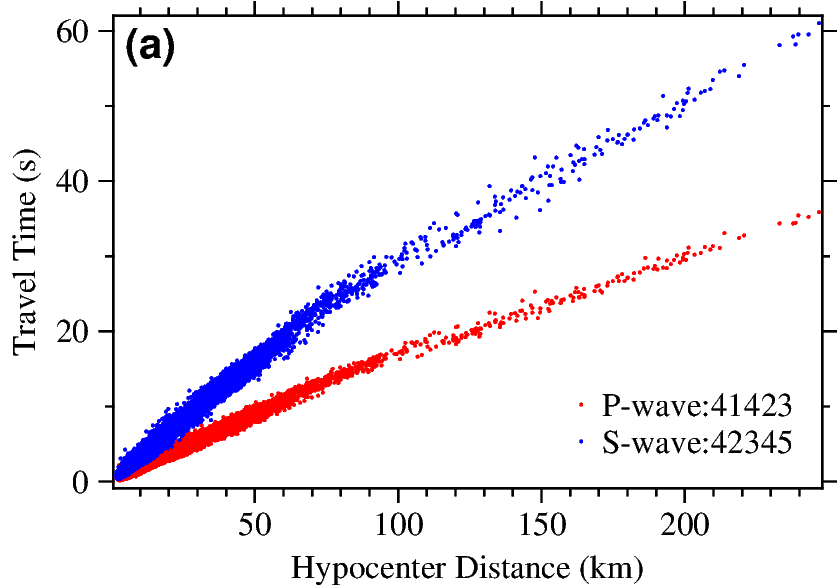

In [6]:
fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region1,projection='X6c/4c',frame=['xaf+lHypocenter Distance (km)','yaf+lTravel Time (s)','WSen'])
fig.plot(x=Tp[ty],y=Tp.tt,style='c0.03c',fill='red',label='P-wave:%s'%len(Tp))
fig.plot(x=Ts[ty],y=Ts.tt,style='c0.03c',fill='blue',label='S-wave:%s'%len(Ts))

fig.text(position='cTL',text='(a)',font='10p,1',offset='j0.1c/0.1c',fill='white')
fig.legend(position = 'JBR+jBR+o0.1c')
fig.show()

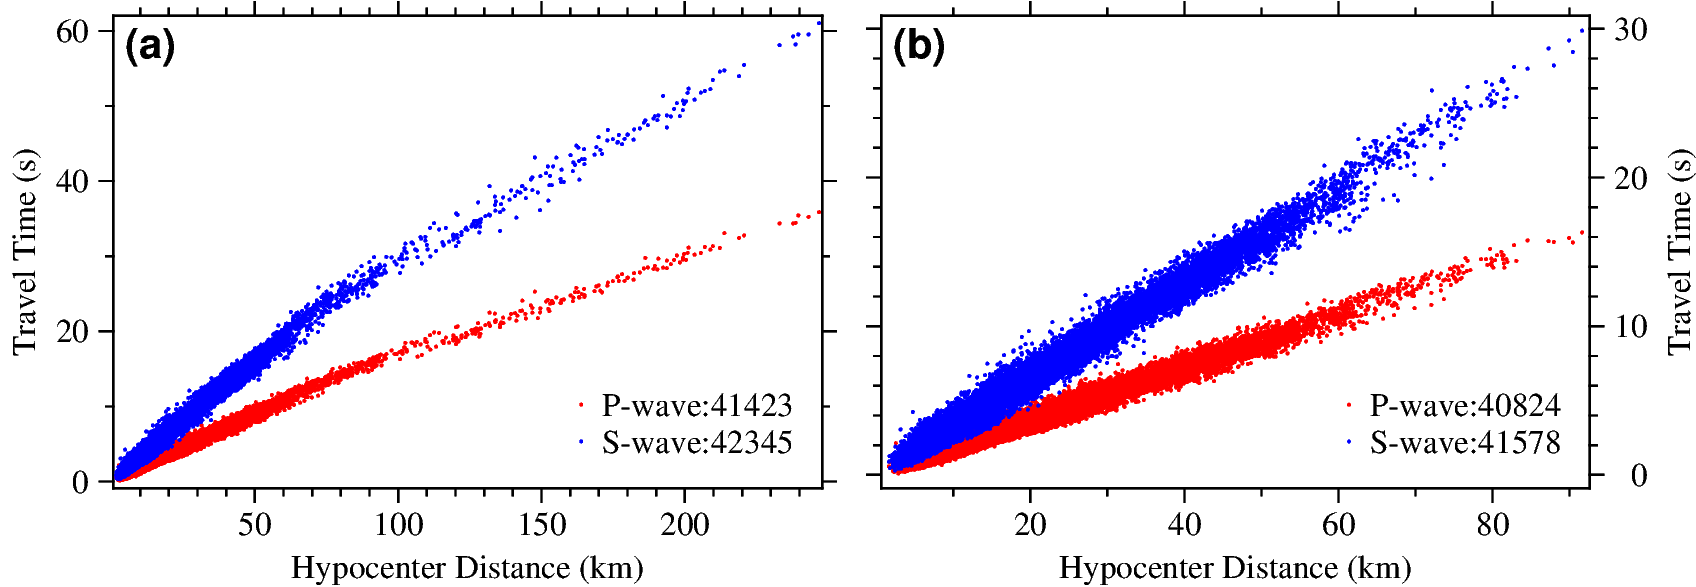

In [7]:
fig.shift_origin(xshift='6.5c')
fig.basemap(region=region2,projection='X6c/4c',frame=['xaf+lHypocenter Distance (km)','yaf+lTravel Time (s)','wSEn'])
fig.plot(x=Tp_ff[ty],y=Tp_ff.tt,style='c0.03c',fill='red',label='P-wave:%s'%len(Tp_ff))
fig.plot(x=Ts_ff[ty],y=Ts_ff.tt,style='c0.03c',fill='blue',label='S-wave:%s'%len(Ts_ff))

fig.text(position='cTL',text='(b)',font='10p,1',offset='j0.1c/0.1c',fill='white')
fig.legend(position = 'JBR+jBR+o0.1c')
fig.show()

In [8]:
# save
fig.savefig('plotting_figures'+os.sep+'Figure2_Ts_Tp.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'Figure2_Ts_Tp.pdf')